# Synthetic Clinical Trial for Down's Syndrome
Given measured device performace metrics (such as sensitivity, selectivity, storage and sample processing variations), estimate the ROC curve. In other given some device variation data, generate the AUC value that would be achieved by the test in clinic?

In other words, simulate an observational clinical trial for Down's syndrome.

```txt
Inputs:
    Device Caliberation Curve with Error Bars, Storage and processing variation data with Error Bars
Outputs:
    ROC Curve and AUC value
```

## Plan

Here is some sample code that we would eventually wish to write:
```py
theoratical_max_roc, theoratical_max_auc = device_model()

roc, auc = device_model(input_file="./raw_data.csv")
plot_roc(roc)
print("AUC based on current device = ", auc)

dr = detection_rate(roc, fpr=0.05)
print("Detection rate achieved at 5% FPR is ", dr)
```

Proposed csv format for Device Caliberation Curve
```csv
concentration,mean,std
-8.32,23.33,3.1
...
```

Proposed csv format for Storage and Processing Variation data
```csv
marker,elapsed_days,mean,std
bhcg,8,23.33,3.1
bhcg,10,24.53,4.2
...
```

### Process
1. ✅ Produce a model of population distribution for down syndrome
    1. Define probability distribution of samples
    2. Generate lots of samples based on the probability distribution (Age, b-hcg, papp-a, NT scan)
2. Model and simulate storage and processing errors
3. Model and simulate sensitivity and selectivity of our sensor
4. ✅ Define a diagnostic algorithm, generate RUC curve and AUC value

Example
1. P(H) = 0.5, P(T) = 0.5 : **Probability Distribution** : Normal Distribution ( Average(X), SD(X) ) / Log Normal Distribution ( Average(log(X)), SD(log(X) )
2. **Random Sampling** (take my distribution) -> then produce a random sample

> Note
> 
> **MoM**: Multiples of Median is used as a gestational age normalized form of the raw values from different markers.

## Modeling of population distribution for down syndrome

In [521]:
# Import libraries
import math
import numpy as np
from dataclasses import dataclass, field
from typing import List, Tuple
from pprint import pprint
import matplotlib.pyplot as plt

In [587]:
# Some helper lambdas to make switching bases easier to log

# Log base 10
lg = np.log10
inv_lg = lambda x: np.pow(10, x)

# Natural Logs
# lg = np.log
# inv_lg = lambda x: np.exp(x)

In [522]:
@dataclass
class Marker:
    """This class is used to define a particular marker. Example, b-hCG."""
    
    name: str # Name of the marker, example: b-hCG
    median_mom_down: float # median MoM for down syndrome patients
    median_mom_control: float # median MoM for control patients
    log_sd_down: float = 0.0 # log of the sd of the marker's MoM values in Down Syndrome cases
    log_sd_control: float = 0.0 # log of the sd of the marker's MoM values in Control cases

In [523]:
@dataclass
class PopulationConfig:
    """
    Maternal Age is Log Normally distributed.
    """
    maternal_age_mean: float = 27.0 # Mean/Average of maternal age in years
    maternal_age_sd: float = 5.5 # SD of maternal age in years

    down_syndrome_prevalence: float = 1/700 # Prevalence of Down syndrome in the population

@dataclass
class MarkersConfig:
    """
    Config for the various markers being analysed
    """
    markers: list[Marker] = field(default_factory=list)
    
    correlation_matrix_down: np.ndarray = field(default_factory=lambda: np.eye(1)) # Correlatiuon matrix for Down syndrome cases
    correlation_matrix_control: np.ndarray = field(default_factory=lambda: np.eye(1)) # Correlation matrix for control cases

    def __post_init__(self):
        self.markers = [
            Marker(name="Free B-hCG", median_mom_down=1.70, median_mom_control=1.01, log_sd_down=0.28, log_sd_control=0.27),
            Marker(name="PAPP-A", median_mom_down=0.49, median_mom_control=1.00, log_sd_down=0.31, log_sd_control=0.25),
            Marker(name="NT", median_mom_down=1.74, median_mom_control=1.01, log_sd_down=0.23, log_sd_control=0.13),
        ]

        markers_count = len(self.markers)
        self.correlation_matrix_down = self.correlation_matrix_control = np.eye(markers_count)

In [524]:
pop_config = PopulationConfig()
marker_config = MarkersConfig()

pprint(pop_config)
pprint(marker_config)

PopulationConfig(maternal_age_mean=27.0,
                 maternal_age_sd=5.5,
                 down_syndrome_prevalence=0.0014285714285714286)
MarkersConfig(markers=[Marker(name='Free B-hCG',
                              median_mom_down=1.7,
                              median_mom_control=1.01,
                              log_sd_down=0.28,
                              log_sd_control=0.27),
                       Marker(name='PAPP-A',
                              median_mom_down=0.49,
                              median_mom_control=1.0,
                              log_sd_down=0.31,
                              log_sd_control=0.25),
                       Marker(name='NT',
                              median_mom_down=1.74,
                              median_mom_control=1.01,
                              log_sd_down=0.23,
                              log_sd_control=0.13)],
              correlation_matrix_down=array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

In [525]:
config.correlation_matrix_control

array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])

## Generate lots of samples based on the probability distribution

In [526]:
sample_size: int = 1_00_000 # Number of samples to be generated from the distribution

In [527]:
# If needed, we can make make the random functions behave the same every time by choosing a seed value
np.random.seed(42)

In [528]:
# Randomly (normally) assign down syndrome to patients based on down syndrome prevalence (usually 1/700)
has_down = np.random.random(sample_size) < pop_config.down_syndrome_prevalence
has_down

array([False, False, False, ..., False, False, False])

In [529]:
sampled_prevalence = (np.sum(is_down) / sample_size)
print(f"We get the prevalence of {sampled_prevalence*100:.2f}% which is similar to the expected value of {1/7:.2f}%")

assert np.allclose(sampled_prevalence, pop_config.down_syndrome_prevalence, atol=1/2000), "Sampled prevalence should be similar to expected prevalence"

We get the prevalence of 0.13% which is similar to the expected value of 0.14%


In [530]:
min_max = lambda v, tol: ((v - tol) * 100, (v + tol) * 100)

min_max(0.0014, 1/2000)

(0.09, 0.19)

Let X be a random variable with a log normal distribution  $N(\mu_X, \sigma^2_X$). Then the $ln(X)$ has the mean $\mu$ and variance $\sigma^2$.

$$
\begin{align}
\mu &= ln({\frac{\mu^2_X}{\sqrt{\mu^2_X + \sigma^2_X}}}) \\
\sigma^2 &= ln(1 + \frac{\sigma^2_X}{\mu^2_X})
\end{align}
$$

In [564]:
mu = np.log10(pop_config.maternal_age_mean**2 / (np.sqrt(pop_config.maternal_age_mean**2 + pop_config.maternal_age_sd**2)))
sig2 = np.log10(1 + (pop_config.maternal_age_sd ** 2 / pop_config.maternal_age_mean ** 2))
sig = np.sqrt(sig2)

log_maternal_ages = np.random.normal(
    mu,
    sig,
    sample_size
)

print(
    mu, sig
)

log_maternal_ages

1.4225351280228231 0.13288066929515427


array([1.45230183, 1.28287848, 1.21256322, ..., 1.36606743, 1.32334795,
       1.3083661 ])

In [565]:
def summary_stats(data: np.ndarray):
    print(f"X ~ N(μ, σ^2): N({np.mean(data):.4f}, {np.std(data):.4f})")
    print(f"Range: {np.min(data):.4f} ≤ X ≤ {np.max(data):.4f}")

    print(f"median (M): {np.median(data):.4f}\n")

inverse of log is exponential

(array([2.800e+01, 2.030e+02, 5.860e+02, 1.390e+03, 2.374e+03, 3.884e+03,
        5.287e+03, 6.512e+03, 7.594e+03, 7.819e+03, 8.154e+03, 7.975e+03,
        7.184e+03, 6.732e+03, 5.955e+03, 5.152e+03, 4.403e+03, 3.600e+03,
        3.053e+03, 2.412e+03, 1.987e+03, 1.653e+03, 1.279e+03, 1.004e+03,
        7.990e+02, 6.620e+02, 5.580e+02, 3.990e+02, 3.140e+02, 2.330e+02,
        1.760e+02, 1.340e+02, 1.230e+02, 8.000e+01, 8.500e+01, 4.200e+01,
        5.200e+01, 3.800e+01, 2.000e+01, 1.100e+01, 1.500e+01, 1.500e+01,
        9.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 3.000e+00, 1.000e+00,
        1.000e+00, 1.000e+00]),
 array([ 7.95186456,  9.52206767, 11.09227077, 12.66247388, 14.23267698,
        15.80288009, 17.37308319, 18.94328629, 20.5134894 , 22.0836925 ,
        23.65389561, 25.22409871, 26.79430182, 28.36450492, 29.93470802,
        31.50491113, 33.07511423, 34.64531734, 36.21552044, 37.78572355,
        39.35592665, 40.92612976, 42.49633286, 44.06653596, 45.63673907,
        47.

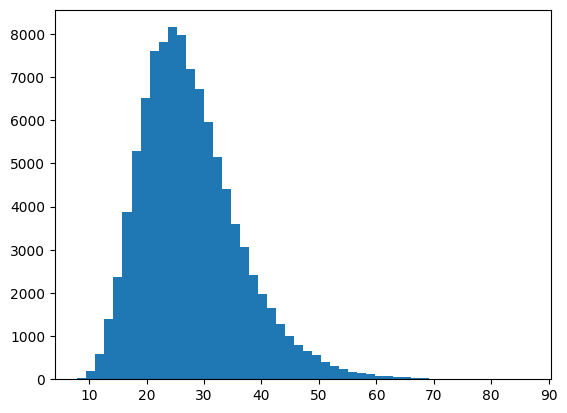

In [569]:
# maternal_age = np.exp(log_maternal_ages)
maternal_age = np.pow(10, log_maternal_ages)
# print(maternal_age)

plt.hist(maternal_age, bins=50)

In [570]:
summary_stats(log_maternal_ages)
# summary_stats(np.exp(log_maternal_ages))
summary_stats(np.pow(10, log_maternal_ages))

X ~ N(μ, σ^2): N(1.4223, 0.1328)
Range: 0.9005 ≤ X ≤ 1.9368
median (M): 1.4220

X ~ N(μ, σ^2): N(27.7102, 8.6668)
Range: 7.9519 ≤ X ≤ 86.4620
median (M): 26.4233



Log normal distribution is defined as:
$$
Y = ln(X), Y \sim N(\mu, \sigma)
$$

In other words, where the log of the random variable Y is normally distributed.

For a log normally distributed random variable X. The median for X is just the exponential of its mean. 
$$
M = e^\mu
=> ln(M) = \mu
$$

In [571]:
# Example
avg = np.log10(0.49)
avg

np.float64(-0.3098039199714863)

In [572]:
# Calculate mean of log10 values for all markers for both down's samples and healthy samples

mean_down = np.log10([m.median_mom_down for m in marker_config.markers]) # Mean for all markers for down's patients
# For example:
#  Median MoM value of Papp-a for Down's is 0.49
#  Given the above relationship between mean and median for a log-normally distributed variable, 
#  we can state that the Mean of Papp-a MoM values for Down's is log10(0.49) = -0.31

mean_control = np.log10([m.median_mom_control for m in marker_config.markers]) # Mean for all markers for healthy patients

mean_down, mean_control

(array([ 0.23044892, -0.30980392,  0.24054925]),
 array([0.00432137, 0.        , 0.00432137]))

### Covariance Matrices

Assuming that $X_i$ for all $i=0...n$ are independent random variables, the $Cov(X_i, Y_j) = 0$ and hence we get the following diagnol form containing only the variances.

$$
Cov(X, X) = \begin{bmatrix}
Var(X_1) & 0 & 0\\
0 & Var(X_2) & 0\\
0 & 0 & Var(X_3)
\end{bmatrix} = \begin{bmatrix}
\sigma^2(X_1) & 0 & 0\\
0 & \sigma^2(X_2) & 0\\
0 & 0 & \sigma^2(X_3)
\end{bmatrix} = diag(\sigma^2(X_1), \sigma^2(X_2), \sigma^2(X_3))
$$

The covariance matrix is a diagonal matrix containing only the variances of each of the markers.

Concretely,
$$
Cov(X, X) = \begin{bmatrix}
Var(Pappa) & 0 & 0\\
0 & Var(\beta hCG) & 0\\
0 & 0 & Var(NT)
\end{bmatrix} = \begin{bmatrix}
\sigma^2(Pappa) & 0 & 0\\
0 & \sigma^2(\beta hCG) & 0\\
0 & 0 & \sigma^2(NT)
\end{bmatrix} = diag(\sigma^2(Pappa), \sigma^2(\beta hCG), \sigma^2(NT))
$$

In [577]:
variance_matrix_down = np.diag([m.log_sd_down**2 for m in marker_config.markers])
variance_matrix_control = np.diag([m.log_sd_control**2 for m in marker_config.markers])

variance_matrix_down, variance_matrix_control

(array([[0.0784, 0.    , 0.    ],
        [0.    , 0.0961, 0.    ],
        [0.    , 0.    , 0.0529]]),
 array([[0.0729, 0.    , 0.    ],
        [0.    , 0.0625, 0.    ],
        [0.    , 0.    , 0.0169]]))

In [578]:
sd_matrix_down = np.sqrt(variance_matrix_down)
sd_matrix_control = np.sqrt(variance_matrix_control)

### Correlation Matrices

In [546]:
[m.name for m in marker_config.markers]

['Free B-hCG', 'PAPP-A', 'NT']

$$
\begin{bmatrix}
Free B-hCG / Free B-hCG & Free B-hCG / PAPP-A & Free B-hCG / NT\\
PAPP-A / Free B-hCG & PAPP-A / PAPP-A & PAPP-A / NT\\
NT / Free B-hCG & NT / PAPP-A & NT / NT\\
\end{bmatrix}
$$

Note: Correlations of markers with NT is assumed to be zero as per the paper (table 3)

In [548]:
# Correlation between different markers for Down's samples
correlation_matrix_down = np.array(
    [[1.,    0.191, 0.],
     [0.191, 1.,    0.],
     [0.,    0.,    1.]]
)

In [549]:
# Correlation between different markers for Healthy samples
correlation_matrix_control = np.array(
    [[1.,    0.186, 0.],
     [0.186, 1.,    0.],
     [0.,    0.,    1.]]
)

In [550]:
cov_down.shape, correlation_matrix_down.shape

((3, 3), (3, 3))

$$
Cov(X) = \sqrt{Cov(X)} Corr(X) \sqrt{Cov(X)}
$$

In [579]:
# Covariance matrix of all markers for Down's patients
cov_down = sd_matrix_down @ correlation_matrix_down @ sd_matrix_down
cov_down

array([[0.0784   , 0.0165788, 0.       ],
       [0.0165788, 0.0961   , 0.       ],
       [0.       , 0.       , 0.0529   ]])

In [580]:
# Covariance matrix of all markers for Healthy patients
cov_control = sd_matrix_control @ correlation_matrix_control @ sd_matrix_control
cov_control

array([[0.0729  , 0.012555, 0.      ],
       [0.012555, 0.0625  , 0.      ],
       [0.      , 0.      , 0.0169  ]])

### Generate Marker Values for all patient samples

In [581]:
# Sample the marker values for each of the down's patients

log_marker_values_down = np.random.multivariate_normal(
    mean_down, # Mean of all markers of all markers for Down's patients
    cov_down, # Covariance matrix of all markers for Down's patients
    np.sum(is_down) # We want to sample these marker values for ALL the down's samples only
)

log_marker_values_down.shape #, log_marker_values_down

(133, 3)

In [582]:
# Sample the marker values for each of the healthy patients

log_marker_values_control = np.random.multivariate_normal(
    mean_control, # Mean of all markers of all markers for healthy patients
    cov_control, # Covariance matrix of all markers for Healthy patients
    np.sum(~is_down) # We want to sample these marker values for ALL the healthy samples only
)

log_marker_values_control.shape #, log_marker_values_control

(99867, 3)

Now, lets put all the marker values together into a single big matrix

In [583]:
log_marker_values = np.zeros((sample_size, len(marker_config.markers)))
log_marker_values.shape

(100000, 3)

In [418]:
log_marker_values[is_down] = log_marker_values_down
log_marker_values[~is_down] = log_marker_values_control

In [419]:
log_marker_values

array([[-0.11497528,  0.28051598,  0.2491788 ],
       [-0.32430664, -0.147406  , -0.18140637],
       [-0.40573785,  0.66809531,  0.06793337],
       ...,
       [ 0.07578579,  0.03609642,  0.18519711],
       [ 0.37674396, -0.09690599, -0.34386122],
       [ 0.052934  ,  0.28484571, -0.09235188]])

Convert all the marker values from log(MoM) to MoM values

In [558]:
# marker_values = np.exp(log_marker_values)
marker_values = np.pow(10, log_marker_values)
marker_values

array([[0.76740517, 1.90772592, 1.77492009],
       [0.47390726, 0.71218693, 0.65855739],
       [0.39288201, 4.65688282, 1.16931997],
       ...,
       [1.1906546 , 1.08666686, 1.53178253],
       [2.3809154 , 0.8000074 , 0.45304233],
       [1.12962422, 1.92684024, 0.80844062]])

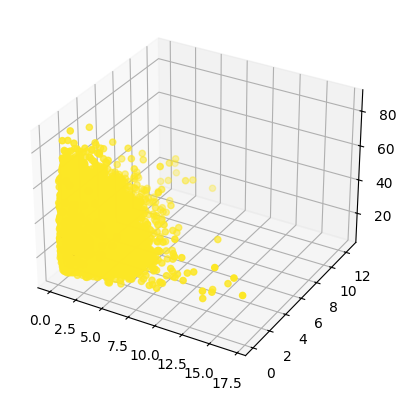

In [573]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

ax.scatter(
    marker_values[:,0], 
    marker_values[:,1],
    # marker_values[:,2],
    maternal_age,
    c=~is_down
)

In [562]:
import plotly.graph_objects as go
import plotly.io as pio
import numpy as np

def create_interactive_plot(marker_values, maternal_age, is_down, marker_config, z_axis='maternal_age'):
    # pio.renderers.default = "browser"

    # Separate Down syndrome and control cases
    down_indices = np.where(is_down)[0]
    control_indices = np.where(~is_down)[0]

    # Determine z-axis values
    if z_axis == 'maternal_age':
        z_values = maternal_age
        z_axis_title = 'Maternal Age'
    elif z_axis == 'NT':
        z_values = marker_values[:, 2]
        z_axis_title = marker_config.markers[2].name
    else:
        raise ValueError("z_axis must be either 'maternal_age' or 'NT'")

    # Create scatter plots for Down syndrome and control cases separately
    scatter_down = go.Scatter3d(
        x=marker_values[down_indices, 0],
        y=marker_values[down_indices, 1],
        z=z_values[down_indices],
        mode='markers',
        marker=dict(
            size=5,
            color='red',
            symbol='diamond',
        ),
        name='Down Syndrome',
        text=[f"Age: {age:.1f}, {z_axis_title}: {z:.2f}, Down Syndrome: True" 
              for age, z in zip(maternal_age[down_indices], z_values[down_indices])],
        hoverinfo="text"
    )

    scatter_control = go.Scatter3d(
        x=marker_values[control_indices, 0],
        y=marker_values[control_indices, 1],
        z=z_values[control_indices],
        mode='markers',
        marker=dict(
            size=3,
            color='blue',
            opacity=0.1,
        ),
        name='Control',
        text=[f"Age: {age:.1f}, {z_axis_title}: {z:.2f}, Down Syndrome: False" 
              for age, z in zip(maternal_age[control_indices], z_values[control_indices])],
        hoverinfo="text"
    )

    # Create the layout
    layout = go.Layout(
        scene=dict(
            xaxis_title=marker_config.markers[0].name,
            yaxis_title=marker_config.markers[1].name,
            zaxis_title=z_axis_title,
        ),
        title="Down Syndrome Screening Markers",
        width=900,
        height=700,
        legend=dict(
            yanchor="top",
            y=0.99,
            xanchor="left",
            x=0.01
        )
    )

    # Create the figure and show it
    fig = go.Figure(data=[scatter_control, scatter_down], layout=layout)

    # Add sliders for marker cutoffs
    for i, marker in enumerate([marker_config.markers[0].name, marker_config.markers[1].name]):
        fig.update_layout(
            sliders=[dict(
                active=0,
                currentvalue={"prefix": f"{marker} Cutoff: "},
                pad={"t": 50},
                steps=[dict(
                    method='update',
                    args=[{'visible': [True, True]},
                          {'title': f'{marker} Cutoff: {cutoff:.2f}'}],
                    label=str(cutoff)
                ) for cutoff in np.linspace(0.5, 2, 20)]
            )]
        )

    fig.show()

In [574]:
# create_interactive_plot(marker_values, maternal_age, is_down, marker_config, z_axis='NT')

In [575]:
create_interactive_plot(marker_values, maternal_age, is_down, marker_config, z_axis='maternal_age')

## Diagnostic algorithm, generate RUC curve and AUC value
- Based on likelihood estimation method as described in the paper

## Model of the device
- For each MoM value of the patient, generate the raw value that would be measured by the device (example: ng/ml)
- Calculate median based on our device generated raw value
- Estimate MoM values based on our device's raw values and gestational age dependent median values

## End to End Analysis